# Closing the loop: Interactive selections inside notebooks

We'll kick off this tutorial with a motivating use case for anywidget to spark your interest and demonstrate its capabilities. 
This section quickly introduces many concepts, which we'll dig into later in the tutorial, so don't worry if it feels fast-paced!

In the live tutorial, this will be done mostly from scratch in a blank notebook.  For those reviewing later, I'll reproduce the examples and discussions here.


## 1. Imports and Data

We'll start with importing some data and tools to play around with in notebooks. `vega_datasets` includes some example datasets that are nice to use. 

For this tutorial, we will use the cars dataset, which includes information about various car models, their performance metrics, and origins.

In [2]:
from vega_datasets import data

cars = data.cars()
cars.head()

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA


The data is in [tidy layout](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html), where each data attribute is a column and each observation is a row. 

## 2. Creating a static visualization

To begin, let's create a static visualization using `seaborn`.


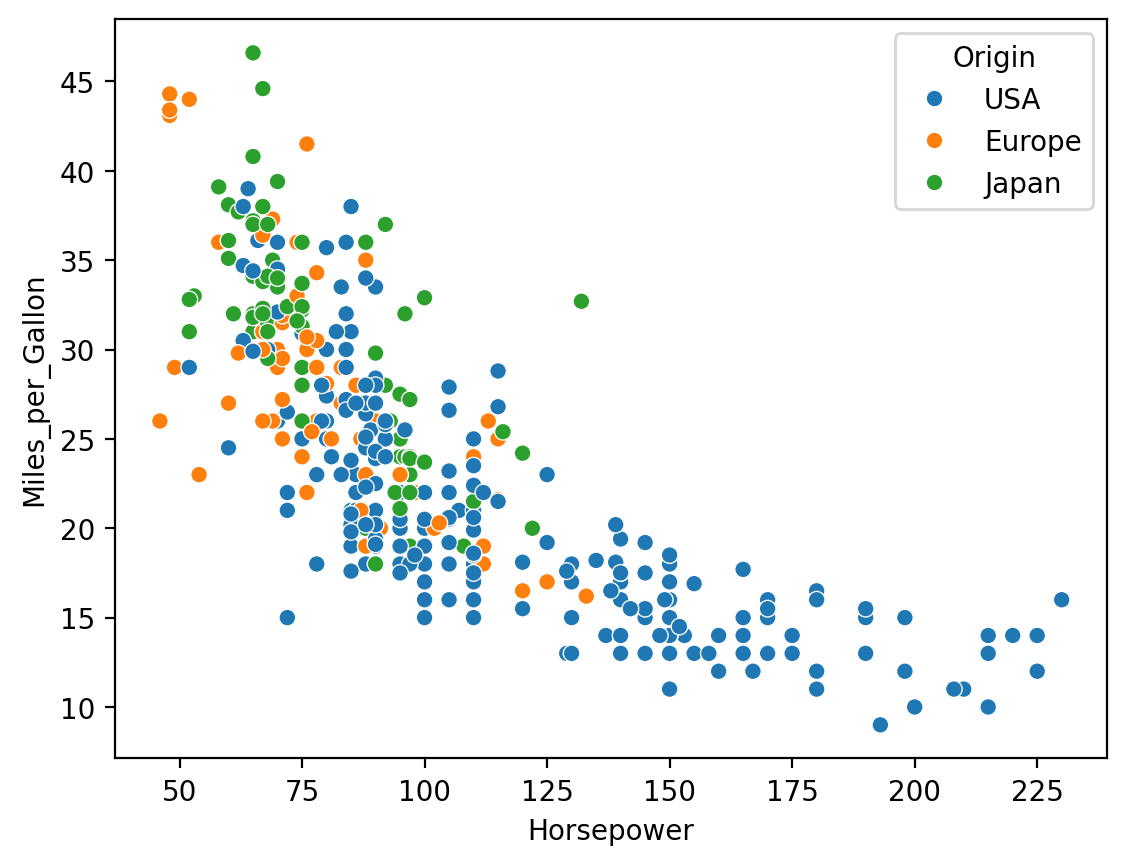

In [3]:
import seaborn as sns

sns.scatterplot(x="Horsepower", y="Miles_per_Gallon", hue="Origin", data=cars);

Here we can see the relationship between miles per gallon (mpg) and horsepower: cars with higher fuel 
efficiency (higher mpg) generally have lower horsepower, indicating that more efficient cars tend 
to have less powerful engines.

We refer to this plot as a "static" visualization because the output is an image (i.e., `.png` or `.jpeg`). 
Although we are looking at the visualization in the browser, the actual pixels have been rasterized by the **_kernel_**,
the Jupyter program responsible for executing code written in notebooks. The **_front end_** (i.e., notebook web
application) simply embeds this data using
an [`<img>`](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/img) element.
You can see this output `<img>` by opening [Developer Tools](https://developer.chrome.com/docs/devtools)
(`Option + ⌘ + I` on Mac, or `F12` on Windows) and hovering over the element.

Notice that the only way to interact with this kind of plot or adjust settings is to re-execute
_kernel_-side code. That means writing new text or executing cells.

For example, if we wanted to see a differnt property mapped to the hue, we'd need to write another cell:

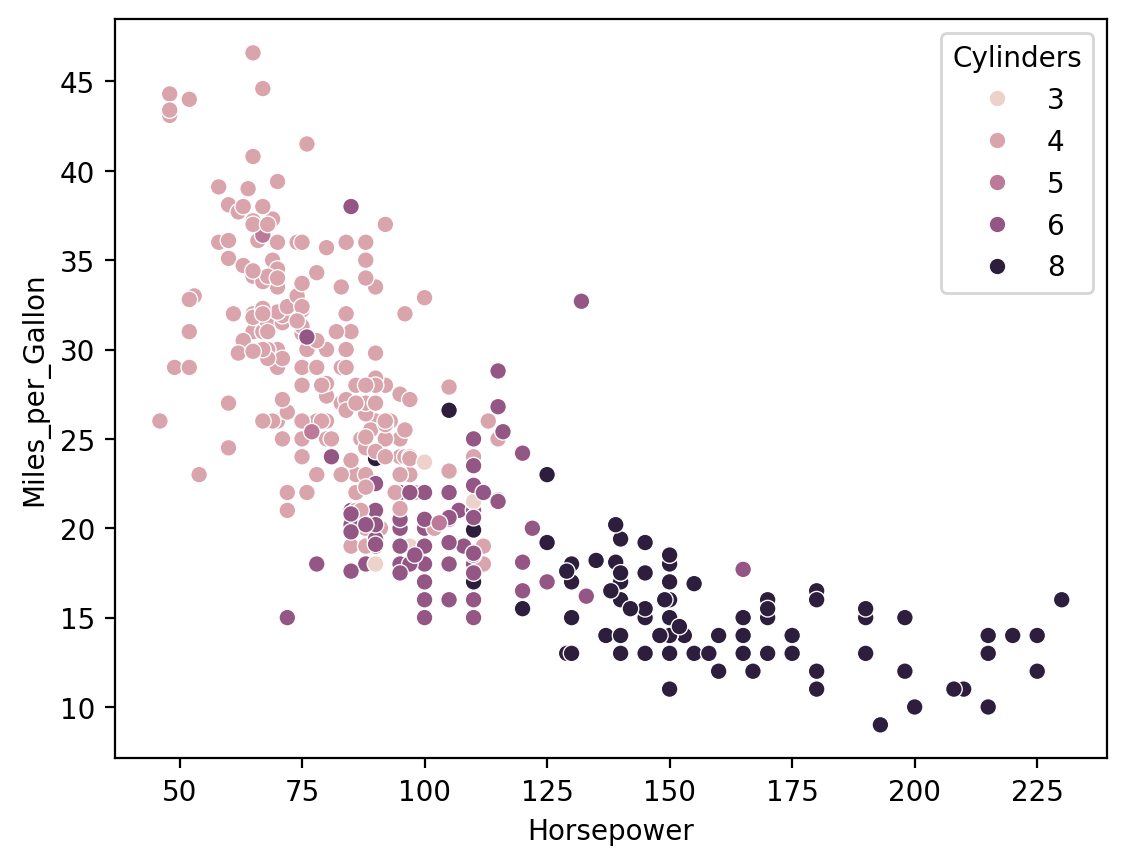

In [4]:
sns.scatterplot(x="Horsepower", y="Miles_per_Gallon", hue="Cylinders", data=cars);

What if we want to have a closer look at a specific point? Do any points jump out as interesting?

To explore this using static plots, you would need to:

- Identify the point visually on the plot.
- Write code to filter the dataset based on the criteria that describe the point.
- Re-run the cell to see the filtered dataset.

For example, the interesting point between 30-35 miles per gallon and 125-150 horsepower. There are no other points around it.

In [5]:
# Filter the dataset to find the interesting point
interesting_point = cars[(cars['Miles_per_Gallon'] > 30) & (cars['Miles_per_Gallon'] < 35) &
                       (cars['Horsepower'] > 125) & (cars['Horsepower'] < 150)]
interesting_point

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
340,datsun 280-zx,32.7,6,168.0,132.0,2910,11.4,1980-01-01,Japan


What if you want to look at another point or group of points? This type of exploration demands **_interactivity_** beyond what notebooks provide with just cell execution. Static plotting libraries are great and produce high-quality figures, but notebooks are also meant for exploration!

It's worth taking a moment to think about this situation: you see an odd data point and want to know "what is that?" Your data is right _here_, in-memory, but you can't easily explore it.

The Python ecosystem is rich for analysis, and the web is the most accessible platform for building custom user interfaces (UIs). 
Jupyter and other Jupyter-compatible platforms (e.g., Google Colab, VS Code) integrate these strengths, offering a powerful
environment for both analysis and interactivity.

Let's see how a little bit of JavaScript changes things...

# 3. A bit of interactivity with Altair

Next, we'll explore how to add some interactivity using [Altair](https://altair-viz.github.io/), a declarative statistical visualization library for Python. Altair allows us to create interactive plots that can help with data exploration directly within the notebook.

We'll start by importing Altair and creating an interactive scatter plot. 

In [6]:
import altair as alt

points = alt.Chart(cars).mark_point().encode(
    x="Horsepower",
    y="Miles_per_Gallon",
    color="Origin",
)

points

alt.Chart(...)

This plot is currently very much like the other, but Altair let's us define more interactive elemnts to our visualiztaion.

For example, let's add a tooltip:

In [7]:
points = alt.Chart(cars).mark_point().encode(
    x="Horsepower",
    y="Miles_per_Gallon",
    color="Origin",
    tooltip=["Name"],
)

points

alt.Chart(...)

We can now more readily identify points of interset _interactively_, nice! 

We can even go further to create linked views with brush selections in a view lines of code:

In [8]:
brush = alt.selection_interval()

points = alt.Chart(cars).mark_point().encode(
    x="Horsepower",
    y="Miles_per_Gallon",
    color=alt.condition(brush, "Origin", alt.value("lightgray")),
    tooltip=["Name"]
).add_params(
    brush
)

bars = points.mark_bar().encode(
    x="count()",
    y="Origin",
    color="Origin"
).transform_filter(
    brush
)

chart = points & bars
chart

alt.VConcatChart(...)

This enables us to select a range of points in the scatter plot and see the corresponding data in a linked bar chart.

So how is Altair different from the static plots before?

Rather than rendering an `<img>` in the *_kernel_*, visualizations in Altair are described as data in text 
form (i.e., the [Vega-Lite](https://vega.github.io/vega-lite/) JSON specification). Altair provides an API for producing 
this specification in Python. The Jupyter notebook embeds this _JSON data_ (not an image) in the front-end, which a JavaScript-based
renderer interprets and renders embeds on the page. Again, you can see this content by opening the Developer Tools and hovering the output element.

We can see the JSON data for our `chart` that Altair sends to the _front end_ by calling `alt.Chart.to_dict` or `alt.Chart.to_json`:

In [17]:
# chart.to_dict() # big Python dictionary
print(chart.to_json()[:500]) # trimmed down for the notebook output

{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.17.0.json",
  "config": {
    "view": {
      "continuousHeight": 300,
      "continuousWidth": 300
    }
  },
  "data": {
    "name": "data-583e73726c1545c56c203344161a975c"
  },
  "datasets": {
    "data-583e73726c1545c56c203344161a975c": [
      {
        "Acceleration": 12.0,
        "Cylinders": 8,
        "Displacement": 307.0,
        "Horsepower": 130.0,
        "Miles_per_Gallon": 18.0,
        "Name": "chevrolet chevelle malibu


JavaScript-based rendering is fundamentally different from static images because the visualizations 
are dynamic and can be interacted with directly in the web browser.

With this kind of interactivity, you might expect to access the selection as a DataFrame back in Python:

In [10]:
chart.selection # <- oh no, error!!!

AttributeError: 'VConcatChart' object has no attribute 'selection'

However, this integration is surface-level. Altair prepares content to embed in the browser using Python,
but once embedded, there is **no more communication**.

You cannot update the visualization from Python (Python -> JS) or send data back to the notebook from the visualization (JS -> Python).
The highlighted points are "trapped" in JavaScript (oh no!).

## Closing the loop with anywidget 

This section of the tutorial demonstrates using **anywidget** to address this exact use case 
(and [long-standing feature request](https://github.com/altair-viz/altair/issues/1153)) in  Altair: retrieving data from a JavaScript selection back into Python.

Previously, we couldn't inspect selected points because the selection is processed in JavaScript, and the HTML-only display lacks a mechanism to communicate back to Python.

Remember, Altair produces JSON following the Vega-Lite visualization grammar. 
With **anywidget**, we can create a custom widget to render this JSON data independently:

In [28]:
import anywidget
import traitlets

class ChartWidget(anywidget.AnyWidget):
    _esm = """
    import embed from "https://cdn.jsdelivr.net/npm/vega-embed@6/+esm";
    async function render({ model, el }) {
      // Get the "spec" trailet from Python
      let spec = model.get("spec"); 
      // Give notebook output element and spec to the Vega-Lite renderer
      let api = await embed(el, spec);
    }
    export default { render };
    """
    spec = traitlets.Dict().tag(sync=True)

widget = ChartWidget(spec=chart.to_dict())
widget

ChartWidget(spec={'config': {'view': {'continuousWidth': 300, 'continuousHeight': 300}}, 'vconcat': [{'mark': …

Whats going on here? Our custom `ChartWidget` is defined by subclassing `anywidget.AnyWidget`:

- `_esm` defines the [ECMAScript module](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Guide/Modules) for the widget. The module
    imports necessary rendering dependencies (vega-embed) and exports `render`: a function to displays the Vega-Lite chart.

- `spec` is a `traitlet`, whichit holds the Vega-Lite JSON specification for the chart. You can think of a traitlet as a Python variables that
   can also be used in JavaScript.

Together, this is essentially the same thing as what we had before in Altair, except now we are rendering the visualization ourselves with a custom widget.

So how do we get the selection? We can use another `traitlet`, let's call it `selection`:

In [34]:
import anywidget
import traitlets

class ChartWidget(anywidget.AnyWidget):
    _esm = """
    import embed from "https://cdn.jsdelivr.net/npm/vega-embed@6/+esm";
    async function render({ model, el }) {
      let spec = model.get("spec");
      let api = await embed(el, spec);
      api.view.addSignalListener(spec.params[0].name, (_, update) => {
        model.set("selection", update);
        model.save_changes();
      });
    }
    export default { render };
    """
    spec = traitlets.Dict().tag(sync=True)
    selection = traitlets.Dict().tag(sync=True)

widget = ChartWidget(spec=chart.to_dict())

# Prints updates log console (JupyterLab: View > Show Log Console)
widget.observe(lambda selection: print(selection.new), names=["selection"])

widget

ChartWidget(spec={'config': {'view': {'continuousWidth': 300, 'continuousHeight': 300}}, 'vconcat': [{'mark': …

The original cross-filtering behavior stays the same, but now we have access to 
the JavaScript selection in Python via `widget.selection`.

The Python callback prints the synchronized selection in the JupyterLab log 
console whenever it changes. Open the JupyterLab logs (View > Show Log Console) to see the updates.

Alternatively, make a new selection and re-run the following cell a few times. Notice how it changes!

In [35]:
widget.selection # make a selection and run me!

{}

## 5. Composing widgets together

Finally, we can present this data more effectively using a second `ipywidget` that 
displays our selection as `pd.DataFrame`.  



In [37]:
import ipywidgets

output = ipywidgets.Output()

@output.capture(clear_output=True, wait=True)
def on_change(change):
    df = cars
    selection = change.new
    for field, (lower, upper) in selection.items():
        df = df[(df[field] > lower) & (df[field] < upper)]
    display(df)

widget.observe(on_change, names="selection")
ipywidgets.VBox([widget, output])

The on_change callback is invoked whenever `widget.selection` changes. It filters the original data based on the `selection` bounds and displays the subset as a table within the output.

Don't worry about understanding all the details here. We aim to show how widgets can be created and used with other widgets from Python. In the next part of the tutorial, we'll dive into each concept introduced in detail, and you'll get hands-on coding experience.

**High-level takeaway**: With just a few lines of code, we enhanced Altair with new functionality using anywidget, and built a custom table viewer.

> Note: This section of the tutorial was adapted from a Jupyter
> [blog post](https://blog.jupyter.org/anywidget-jupyter-widgets-made-easy-164eb2eae102)
> introducing anywidget. This post actually led to Altair implementing their
> own widget with `anywidget`, shipping the long-standing feature request! 🎉
> You can try out the altair widget with [`alt.JupyterChart`](https://altair-viz.github.io/user_guide/jupyter_chart.html).